In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [86]:
from datetime import datetime

In [52]:
import statsmodels.api as sm
import numpy as np

In [101]:
lng_df = pd.read_csv('LNG.csv')
spy_df = pd.read_csv('SPY.csv')

In [102]:
lng_df = lng_df.set_index('Date')
lng_df.index= pd.to_datetime(lng_df.index, format = '%Y-%m-%d')

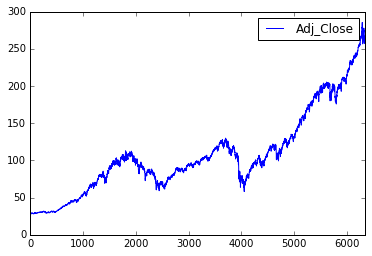

In [103]:
spy_df[['Adj_Close']].plot(label='SPY', legend=True)

In [104]:
spy_df_rt = spy_df['Adj_Close'].pct_change(1)

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.034733
5d_close_future_pct     -0.034733             1.000000


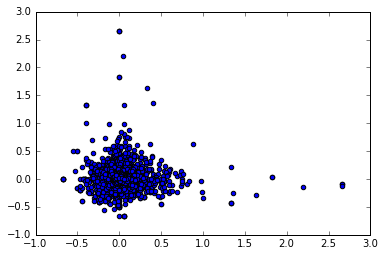

In [105]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future (using historical data)
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'])
plt.show()

In [106]:
for n in [10,20,50,200]:
    
    lng_df['MA'+ str(n)] = lng_df['Adj_Close'].rolling(window=n).mean()
    
    lng_df['MA'+ str(n)+'_5D_Ret'] = lng_df['MA'+ str(n)].pct_change(5)

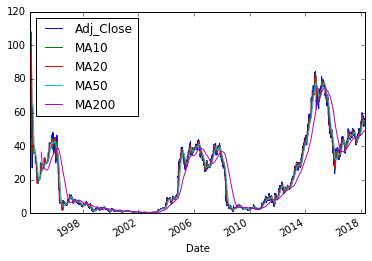

In [107]:

cols = ['MA' + str(n) for n in [10,20,50,200]]
    
lng_df[['Adj_Close'] + cols ].plot()

lng_df = lng_df.dropna()

In [108]:
features_cols = ['MA' + str(n) + '_5D_Ret'  for n in [10,20,50,200]] + ['5d_close_pct']

In [109]:
feat_df = lng_df[features_cols]
target_df = lng_df['5d_close_future_pct']

In [110]:
ln_features = sm.add_constant(feat_df)

C:\Users\bhara\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [111]:
train_size = int(0.85 * ln_features.shape[0])
train_features = ln_features[:train_size]
train_targets = target_df[:train_size]
test_features = ln_features[train_size:]
test_targets = target_df[train_size:]

In [112]:
print(ln_features.shape, train_features.shape, test_features.shape)

(5843, 6) (4966, 6) (877, 6)


In [113]:
model = sm.OLS(train_targets, train_features)

In [114]:
results = model.fit()

In [115]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     5d_close_future_pct   R-squared:                       0.006
Model:                             OLS   Adj. R-squared:                  0.005
Method:                  Least Squares   F-statistic:                     6.073
Date:                 Mon, 26 Aug 2019   Prob (F-statistic):           1.30e-05
Time:                         19:09:10   Log-Likelihood:                 2225.5
No. Observations:                 4966   AIC:                            -4439.
Df Residuals:                     4960   BIC:                            -4400.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0110      0.002      4.974      0.000       0.007       0.015
MA10_5D_Ret      0.1047      0.040      2.643      0.008       0.027       0.182
MA20_5D_Ret     -0.2536      0.059     -4.315      0.000      -0.369      -0.138
MA50_5D_Ret      0.0186      0.073      0.255      0.799      -0.125       0.162
MA200_5D_Ret    -0.1563      0.104     -1.501      0.133      -0.360       0.048
5d_close_pct     0.0024      0.016      0.144      0.885      -0.030       0.035
==============================================================================
Omnibus:                     5206.600   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           942070.098
Skew:                           4.840   Prob(JB):                         0.00
Kurtosis:                      69.777   Cond. No.                         49.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
results.pvalues

const           6.789009e-07
MA10_5D_Ret     8.237767e-03
MA20_5D_Ret     1.628956e-05
MA50_5D_Ret     7.986953e-01
MA200_5D_Ret    1.333792e-01
5d_close_pct    8.854613e-01
dtype: float64

In [120]:
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

In [ ]:
plt.scatter(train_targets, train_predictions, alpha=0.2, color='b', label='train')

plt.scatter(test_targets,test_predictions, alpha=0.4, color='r', label='test')


plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.gca().legend()

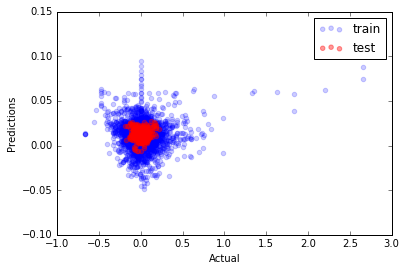